## Теоретическая часть


1. Ответьте на вопросы:  
В чем принципиальное отличие гибридных рекомендательных систем от коллаборативной филтьтрации?  
Приведите 2-3 примера задач, в которых необходимо использовать гибридные системы

только гибридные системы учитывают признаки юзеров и товаров

Примеры: задачи "холодного старта" при появлении нового юзера, который не взаимодействовал ни с чем
 тж проблема "холодного старта" при запуске нового товара или направления

2.  Прочитайте статью про поиск на hh.ru https://habr.com/ru/company/hh/blog/347276/
Нам интересна именно рекомендательная система, раздел "Производительность системы" можно пропустить
Какие основные отличия предложенной системы от тех подходов, которые мы разбирали на семинарах? Какие проблемы могут возникнуть при выводе такой модели в продакшен?


последовательно используются несколько этапов фильтрации
на последнем этапе XGBoost ранжирует вакансии


3. На вебинаре мы рассматривали модель LightFM (https://making.lyst.com/lightfm/docs/lightfm.html). В работе Data Scientist'а важную часть занимает research - исследование существующих архитектур и разбор научных статей, в которых они описываются. Вам предлагается изчуть оригинальную статью про LightFM https://arxiv.org/pdf/1507.08439.pdf и ответить на следующие вопросы:  
1) Какой датасет используют авторы?  
2) Что используют в качестве признаков?  
3) С какими моделями сравнивают LightFM? Опишите их основные идеи кратко  



датасет - MovieLens 10M + Tag Genome (признаки: Юзер x Фильм + упоминания о фильмах)
датасет - CrossValidated (признаки: Юзер х Вопрос) - цель рекоммендации подобрать те вопросы на которые у пользователи смогут ответить с большей вероятностью.

Признаки:
Для MovieLens - жанры, тэги, рейтинг тега, оценки пользователей
Для CrossValidated - вопросы пользователей и ответы на них

MF - матричная модель User х Item с функцией сигмойды
LSI-LR - включает в себя логистическую регрессию. Основывется на факторизации матрицы содержания.
LSI-UP: гибридная модель (представляющая профили пользователей (UP) в виде линейных комбинаций векторов содержимого элементов)

## Практическая часть


In [572]:
pip install lightfm

Note: you may need to restart the kernel to use updated packages.


In [573]:
import lightfm

In [712]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as plt
import matplotlib.image as img
import seaborn as sns
import matplotlib.pyplot as plt

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from src.utils import prefilter_items

In [713]:
from src.metrics import precision_at_k as precision_at_k_,  recall_at_k as recall_at_k_

In [714]:
import lightfm.evaluation
pr = lightfm.evaluation.precision_at_k

### 1. Модуль SRC

На вебинаре было рассказано про модуль src. Он приложен в материалах. Скачайте его, изучите структуру, импортируйте функции

### 2. Работа с признаками

У нас есть внешние данные. Что с ними не так? Чего не хватает?  

Проведите исследование внешних данных и составьте какие-нибудь содержательные выводы.  
Формально Вам нужно построить 3+ графиков (scatter plot, hist или что-то иное) и описать, что мы видим (например, товары такой-то категории болле часто покупаются в следующие дни недели или пользователи с большим достатком предпочитают такие-то товары).  
Исследуйте те закономерности, которые Вам интересно, чем менее тривиальный вывод получается, тем лучше! 

In [715]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [578]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [579]:
item_features['department'].unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [580]:
item_features['commodity_desc'].nunique()

308

In [581]:
item_features['department'].nunique()

44

In [582]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [583]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age_desc             801 non-null    object
 1   marital_status_code  801 non-null    object
 2   income_desc          801 non-null    object
 3   homeowner_desc       801 non-null    object
 4   hh_comp_desc         801 non-null    object
 5   household_size_desc  801 non-null    object
 6   kid_category_desc    801 non-null    object
 7   user_id              801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


In [584]:
user_features['age_desc'].unique()

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

In [585]:
user_features['marital_status_code'].unique()

array(['A', 'U', 'B'], dtype=object)

In [586]:
user_features['household_size_desc'].unique()

array(['2', '3', '4', '1', '5+'], dtype=object)

In [587]:
user_features['income_desc'].unique()

array(['35-49K', '50-74K', '25-34K', '75-99K', 'Under 15K', '100-124K',
       '15-24K', '125-149K', '150-174K', '250K+', '175-199K', '200-249K'],
      dtype=object)

In [588]:
data_all = pd.merge(data, item_features[['item_id', 'department', 'brand', 'commodity_desc']], how='left', on="item_id")
data_all = pd.merge(data_all, user_features, how='left', on="user_id")
data_all.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,department,brand,commodity_desc,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,...,PRODUCE,Private,POTATOES,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,...,PRODUCE,National,ONIONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,...,PRODUCE,Private,VEGETABLES - ALL OTHERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,...,PRODUCE,National,TROPICAL FRUIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,...,PRODUCE,Private,ORGANICS FRUIT & VEGETABLES,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [589]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2396804 entries, 0 to 2396803
Data columns (total 22 columns):
 #   Column               Dtype  
---  ------               -----  
 0   user_id              int64  
 1   basket_id            int64  
 2   day                  int64  
 3   item_id              int64  
 4   quantity             int64  
 5   sales_value          float64
 6   store_id             int64  
 7   retail_disc          float64
 8   trans_time           int64  
 9   week_no              int64  
 10  coupon_disc          float64
 11  coupon_match_disc    float64
 12  department           object 
 13  brand                object 
 14  commodity_desc       object 
 15  age_desc             object 
 16  marital_status_code  object 
 17  income_desc          object 
 18  homeowner_desc       object 
 19  hh_comp_desc         object 
 20  household_size_desc  object 
 21  kid_category_desc    object 
dtypes: float64(4), int64(8), object(10)
memory usage: 420.6+ MB


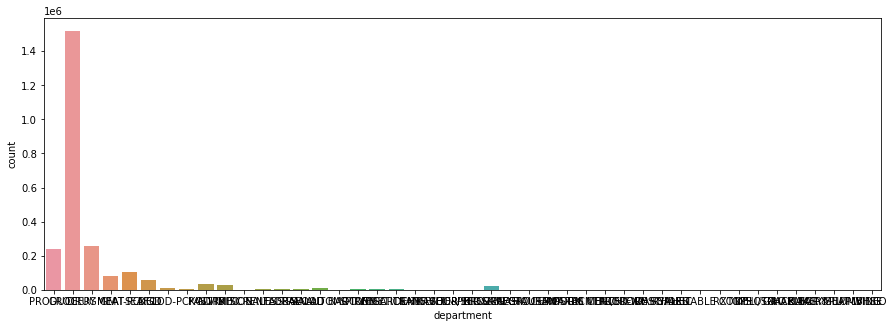

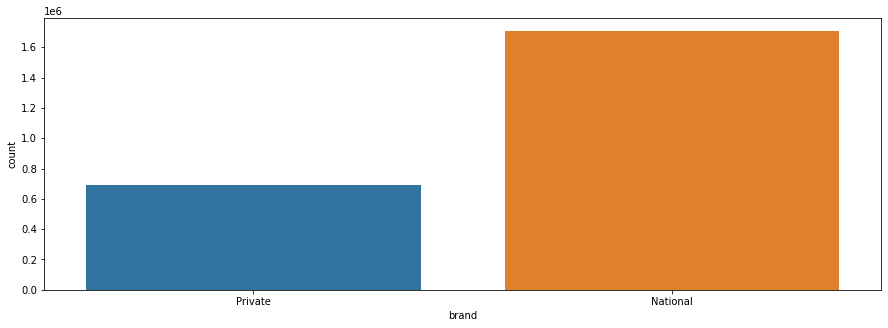

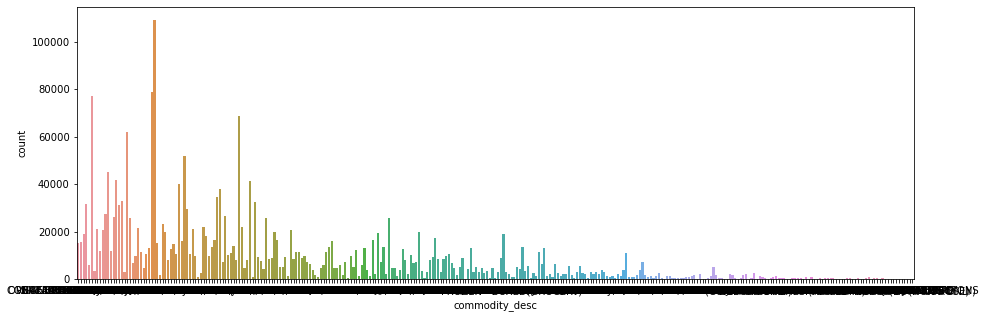

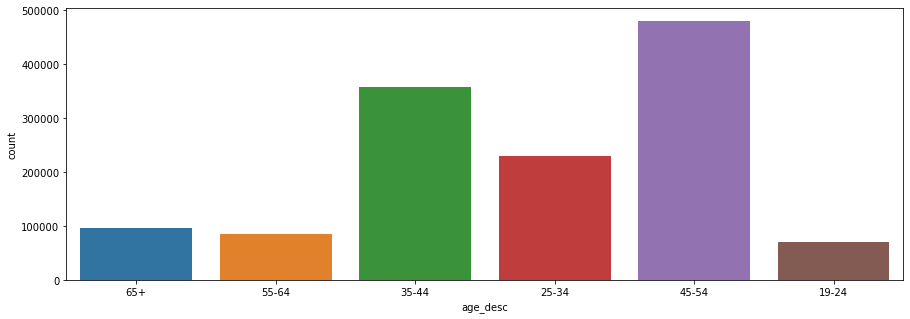

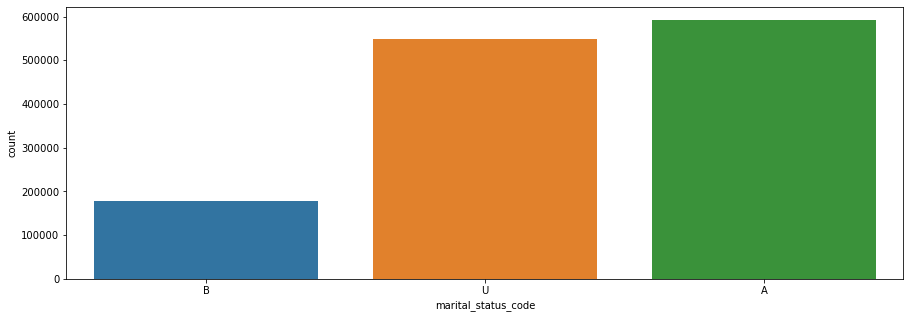

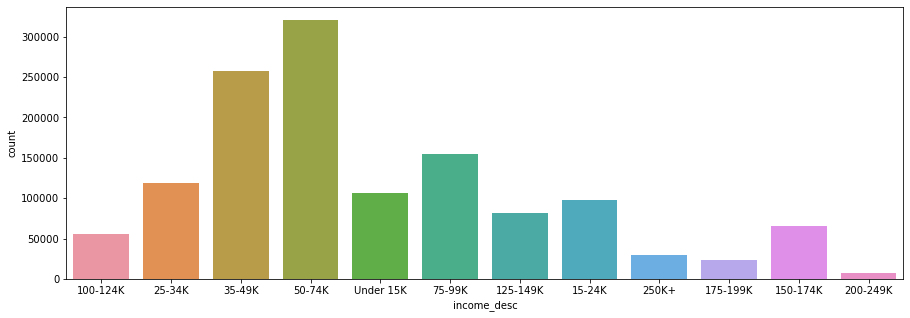

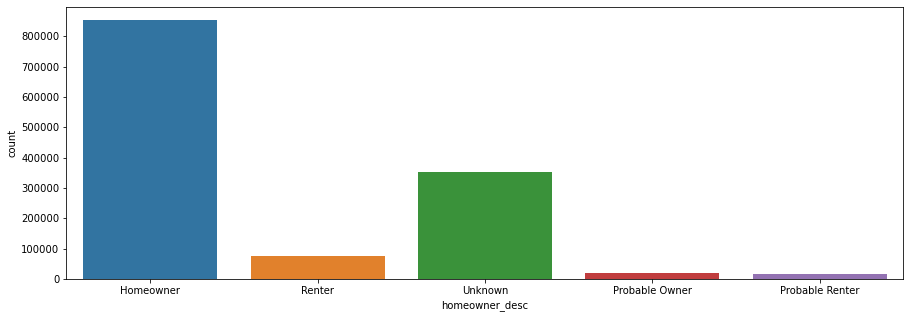

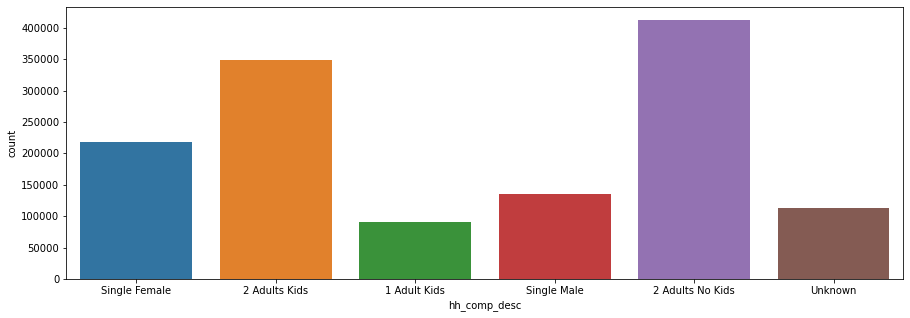

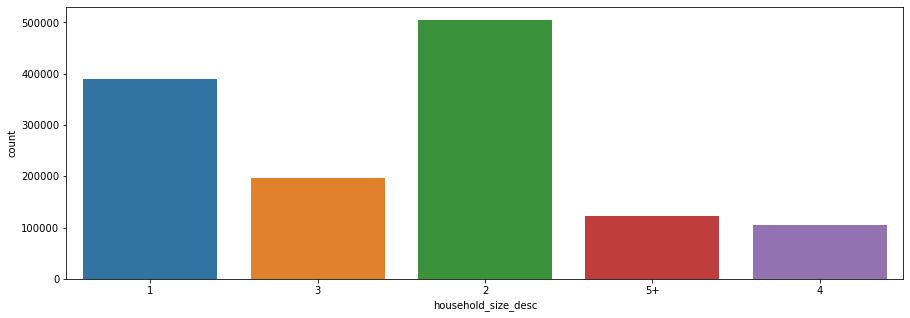

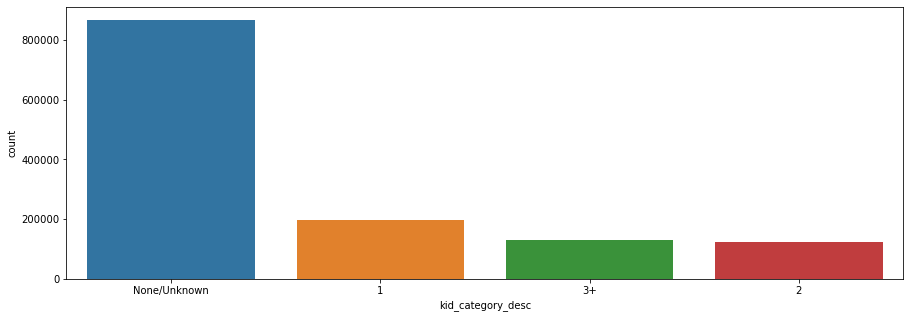

In [590]:
#по категориальным признакам можно посмотреть количественное распределение
import seaborn


for column in data_all.columns:
    
    if data_all[column].dtypes == 'object':
        plt.figure(figsize=(15, 5))

        sns.countplot(x=column, data=data_all)
        #plt.title('')

        plt.show()

In [591]:
# удивительно, но самые популярные отделы товаров одинаковые у всех категорий по доходам, немного только отличается порядок
pop_dep_by_income = data_all.groupby(['income_desc', 'department'], as_index=False).agg({'quantity':'sum'})\
                       .rename(columns={'quantity':'count_in_dep'})

pop_dep_by_income = pop_dep_by_income.sort_values(['income_desc','count_in_dep'],ascending=False).groupby('income_desc').head(3)
pop_dep_by_income

,income_desc,department,count_in_dep
335,Under 15K,KIOSK-GAS,8526950
338,Under 15K,MISC SALES TRAN,1214601
333,Under 15K,GROCERY,96770
302,75-99K,KIOSK-GAS,18886779
305,75-99K,MISC SALES TRAN,848068
301,75-99K,GROCERY,129549
269,50-74K,KIOSK-GAS,36800775
273,50-74K,MISC SALES TRAN,3224582
267,50-74K,GROCERY,262244
234,35-49K,KIOSK-GAS,23941573


### 3. LightFM

У этого алогритма есть множество параметров (item/user_alpha, loss, no_components).  
Проведите эксперименты аналогично дз 3 (подберите гипперпараметры каким удобно способои и постройте графики)  
На выходе необходимо получить pr@5 на валидации (последние 3 недели) > 17%  

У Вас, скорее всего, возникнет проблема со временем обучения. Почему они возникает?    

Попробуйте запустить алгоритм вообще без фичей или используйте только признаки с небольшим числом уникальных категорий. (item_features['commodity_desc'].unique() - 300 уникальных категорий - это очень много)

### *Отбор признаков* * 

Все данные категориальные, при ohe кодировании для товаров признаков становится невероятно много.      
Какие стратегии отбора признаков в классическом ML Вы знаете? Применимы ли они тут?  

Попробйте какие-нибудь стратегии. Удалось ли улучшить качество?

 \* *задание необязательно*


In [640]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


## 1. Filter items

In [716]:
n_items_before = data_train['item_id'].nunique()

data_train = prefilter_items(data_train)

n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 86865 to 5001


In [717]:
data_test = prefilter_items(data_test)

## 2. Prepare data set

In [718]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
#data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999 - уже сделано в src

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='mean', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(2)

item_id,117847,279994,818981,819255,819308,819400,819487,819590,819594,819840,...,15926775,15926844,15926886,15972074,15972298,15972565,15972790,16100266,16729299,16729415
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [719]:
#data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]
test_user_item_matrix = pd.pivot_table(data_test, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='mean', 
                                  fill_value=0
                                 )

test_user_item_matrix = test_user_item_matrix.astype(float)
sparse_user_item_test = csr_matrix(test_user_item_matrix).tocsr()

In [720]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

## 3. Prepare user and item features

In [652]:
user_item_matrix.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500],
           dtype='int64', name='user_id', length=2497)

In [653]:
user_features

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16
...,...,...,...,...,...,...,...,...
796,35-44,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494
797,45-54,A,75-99K,Homeowner,Unknown,3,1,2496
798,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown,2497
799,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498


In [738]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
#.drop(columns=['...''])
user_feat.set_index('user_id', inplace=True)

#уберем слишком многочисленные категории commodity_desc', 'sub_commodity_desc', 'curr_size_of_product' 'manufacturer','commodity_desc',
#'manufacturer', 'department', 'brand', 'commodity_desc','sub_commodity_desc', 'curr_size_of_product'
# .drop(columns=['sub_commodity_desc', 'curr_size_of_product'])
item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat.set_index('item_id', inplace=True)

user_feat.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [739]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())

In [740]:
#user_feat_lightfm.head(2)

In [741]:
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [742]:
#item_feat_lightfm.head()

In [692]:
model = LightFM(no_components=44,
                loss='bpr', # 'warp' 'bpr'
                learning_rate=0.05, 
                item_alpha=0.1, user_alpha=0.1, 
                random_state=42)

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15, 
          num_threads=4) 

In [693]:
user_biases_emb = model.get_user_representations(
    features=csr_matrix(user_feat_lightfm.values).tocsr()
)

Зачем мы снова передаем фичи пользователей? Ведь модель уже обучилась на них

Ответ - для передачи новых значений фичей $f_k$. Эмбеддинги мы действительно уже зафиксировали.

In [694]:
len(user_biases_emb)

2

In [695]:
user_biases_emb[0].shape

(2497,)

по 1 числу для каждого пользователя $b_u$ 

In [696]:
user_biases_emb[1].shape

(2497, 44)

тк no_components = 10

In [697]:
item_emb = model.get_item_representations(
    features=csr_matrix(item_feat_lightfm.values).tocsr())

In [698]:
item_emb[0].shape

(5001,)

In [699]:
item_emb[1].shape

(5001, 44)

In [700]:
train_precision = pr(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

In [701]:
train_precision

0.21097319

In [702]:
#user_feat_lightfm

In [703]:
#item_feat_lightfm

In [704]:
test_precision = pr(model, sparse_user_item_test, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()

In [705]:
test_precision

0.002609132

In [706]:
test_item_ids = np.arange(len(itemids))

predictions = model.predict(user_ids=6, item_ids=test_item_ids,
                            user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                            item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                            num_threads=4)

In [707]:
np.sort(predictions)[::-1]

array([-2.06264570e+04, -2.19433633e+04, -2.19440410e+04, ...,
       -1.31767304e+08, -1.31767304e+08, -1.31767304e+08], dtype=float32)

predictions - некоторые числа. 

In [743]:
model = LightFM(no_components=44,
                loss='warp', # 'warp' 'bpr'
                learning_rate=0.05, 
                item_alpha=0.1, user_alpha=0.1, #если убирать фичи товара, то здесь только с нулями считает пресижн
                random_state=42)

model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
          epochs=15, 
          num_threads=4) 

In [744]:
train_precision = pr(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()
train_precision

0.29411295

In [710]:
%%time
no_components_list = [10, 30, 44, 60, 100] # уменьшала признаки товаров, уменьшала num_threads=4
loss_list = ['bpr', 'warp']
item_alpha_list = [0.05, 0.1] #c 0.15 и больше выходила ошибка
user_alpha_list = [0.05, 0.1]
params = []


for components in no_components_list:
    for loss in loss_list:
        for item_alpha in item_alpha_list:
            for user_alpha in user_alpha_list:
                
                
                model = LightFM(no_components=components,
                                loss=loss,
                                learning_rate=0.05,
                                item_alpha=item_alpha, 
                                user_alpha=user_alpha,
                                random_state=42)
                
                model.fit((sparse_user_item > 0) * 1,  # user-item matrix из 0 и 1
                          sample_weight=coo_matrix(user_item_matrix),  
                          user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                          item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                          epochs=15, num_threads=4)
                precision = pr(model, sparse_user_item, 
                                 user_features=csr_matrix(user_feat_lightfm.values).tocsr(),
                                 item_features=csr_matrix(item_feat_lightfm.values).tocsr(),
                                 k=5).mean()
                
                params_row = []
                params_row.append([components, loss, item_alpha, user_alpha, precision])
                params.append(params_row)               

CPU times: user 32min 57s, sys: 23 s, total: 33min 20s
Wall time: 36min 8s


In [711]:
for i in sorted(params, key=lambda x: x[0][4], reverse=True):
    
    print(f'no_comp: {i[0][0]}, loss: {i[0][1]}, item_a: {i[0][2]}, user_a: {i[0][3]}, precision: {i[0][4]}')

no_comp: 10, loss: warp, item_a: 0.05, user_a: 0.05, precision: 0.2941129505634308
no_comp: 10, loss: warp, item_a: 0.1, user_a: 0.05, precision: 0.2941129505634308
no_comp: 10, loss: warp, item_a: 0.1, user_a: 0.1, precision: 0.2941129505634308
no_comp: 30, loss: warp, item_a: 0.05, user_a: 0.05, precision: 0.2941129505634308
no_comp: 30, loss: warp, item_a: 0.1, user_a: 0.05, precision: 0.2941129505634308
no_comp: 30, loss: warp, item_a: 0.1, user_a: 0.1, precision: 0.2941129505634308
no_comp: 44, loss: warp, item_a: 0.05, user_a: 0.05, precision: 0.2941129505634308
no_comp: 44, loss: warp, item_a: 0.1, user_a: 0.05, precision: 0.2941129505634308
no_comp: 44, loss: warp, item_a: 0.1, user_a: 0.1, precision: 0.2941129505634308
no_comp: 60, loss: warp, item_a: 0.05, user_a: 0.05, precision: 0.2941129505634308
no_comp: 60, loss: warp, item_a: 0.1, user_a: 0.05, precision: 0.2941129505634308
no_comp: 60, loss: warp, item_a: 0.1, user_a: 0.1, precision: 0.2941129505634308
no_comp: 100, lo

In [ ]:
# Подскажите, почему с warp получаются нули на precision? в чем дело, ведь в целом с ним лучше должен был быть precision
# и здесь более важная оказалась user alpha, чем она больше, тем выше метрика